In [1]:
# impodting libraries
import numpy as np
import pandas as pd
import pathlib as Path
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import simplefilter
simplefilter('ignore') # ignore warnings to clean up output cells

In [19]:
# set matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout = True, figsize = (11,4), titlesize = 14, titleweight = 'bold')
plt.rc('axes', titlesize = 14, titleweight = 'bold', titlepad = 10, labelweight = 'bold', labelsize = 'large' )
plt_params = dict(color = '0.75', style = '.-', markeredgecolor = '0.25', markerfacecolor= '0.25', legend = False)

# make the map more attractive
%matplotlib inline
%config InlineBackend.figure_formats = 'retina'

# Load Tunnel Traffic dataset
data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index('Day').to_period()

In [20]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [23]:
tunnel.dtypes

NumVehicles    int64
dtype: object

<Axes: title={'center': 'Tunnel Traffic - 365 day moving average'}, xlabel='Day'>

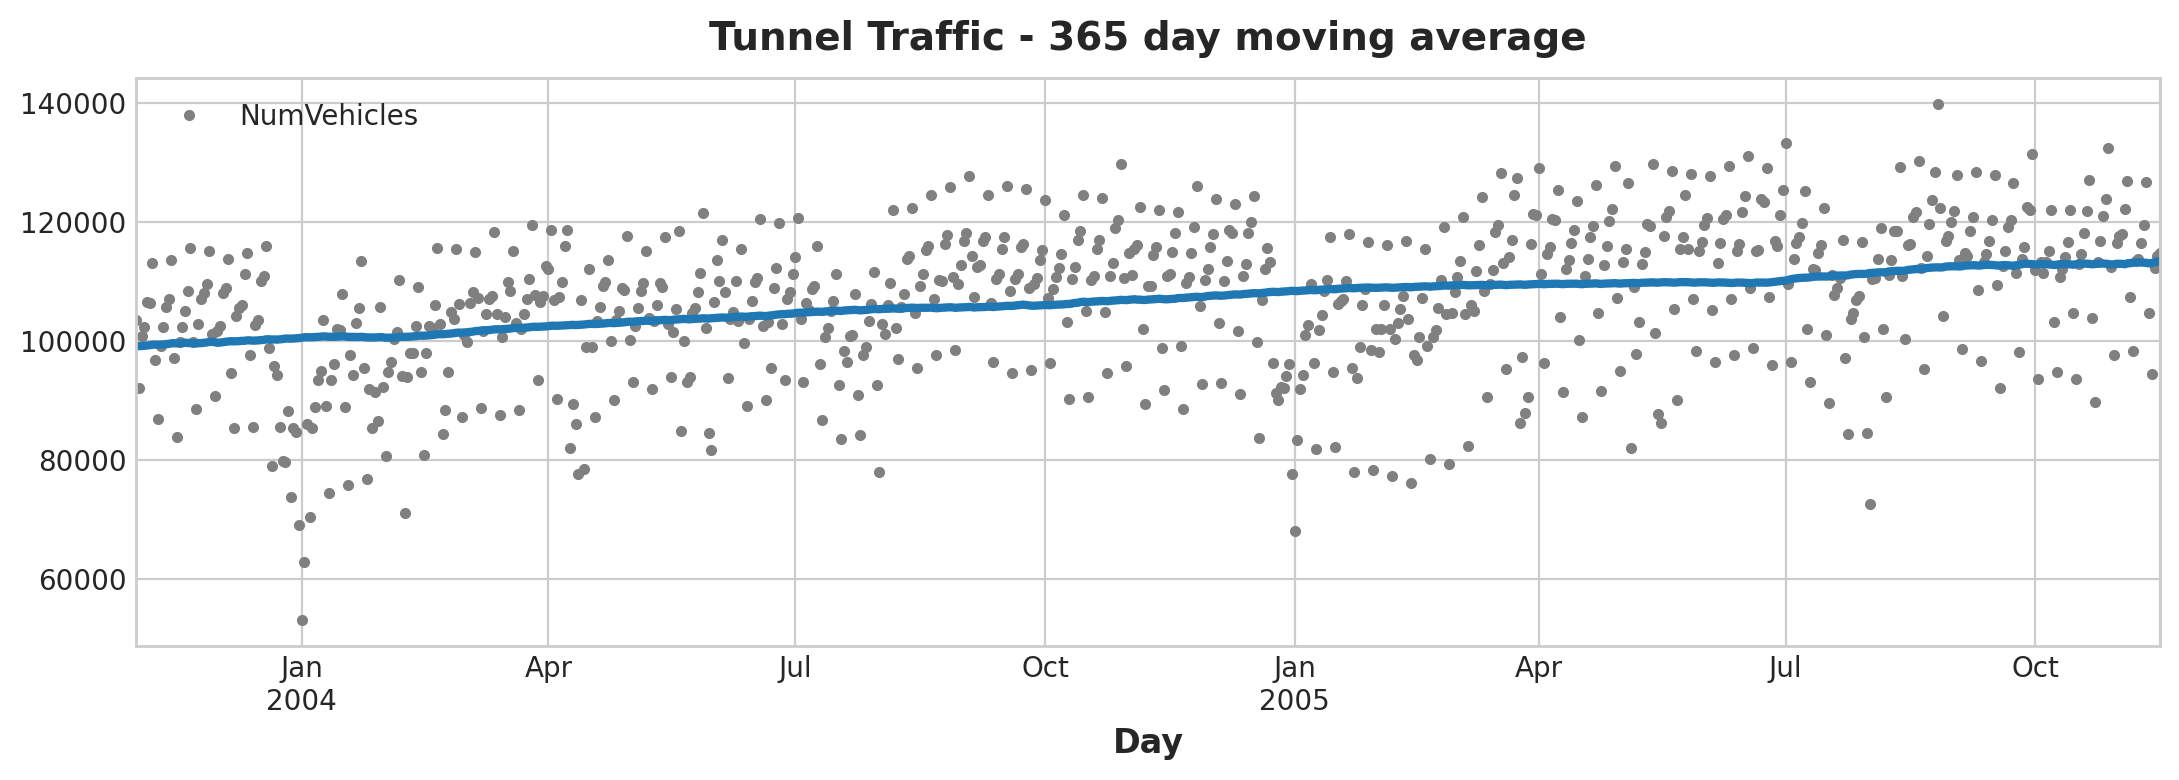

In [36]:
moving_average = tunnel.rolling(
    window = 365, # 365 day window
    center=True, # puts the average at the center of the window
    min_periods = 183, # choose about half the window size
).mean() #computer the mean (also works with median, mode, min, max)

ax = tunnel.plot(style=".",color = '0.5')
moving_average.plot(ax=ax, linewidth = 3, title = 'Tunnel Traffic - 365 day moving average', legend = False)

In [31]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index = tunnel.index, # dates from training data
                         constant = True,# dummy eatures for the bias(y_intercept)
                         order = 1, # the dummy values(trned)
                         drop = True, # drop items if necessary to avoid collinearity
                         )

# creates features for the dates given in the index argument
X = dp.in_sample()
X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [37]:
from sklearn.linear_model import LinearRegression
y = tunnel['NumVehicles'] # the target
model = LinearRegression(fit_intercept = False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index = X.index)
y_pred

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Freq: D, Length: 747, dtype: float64

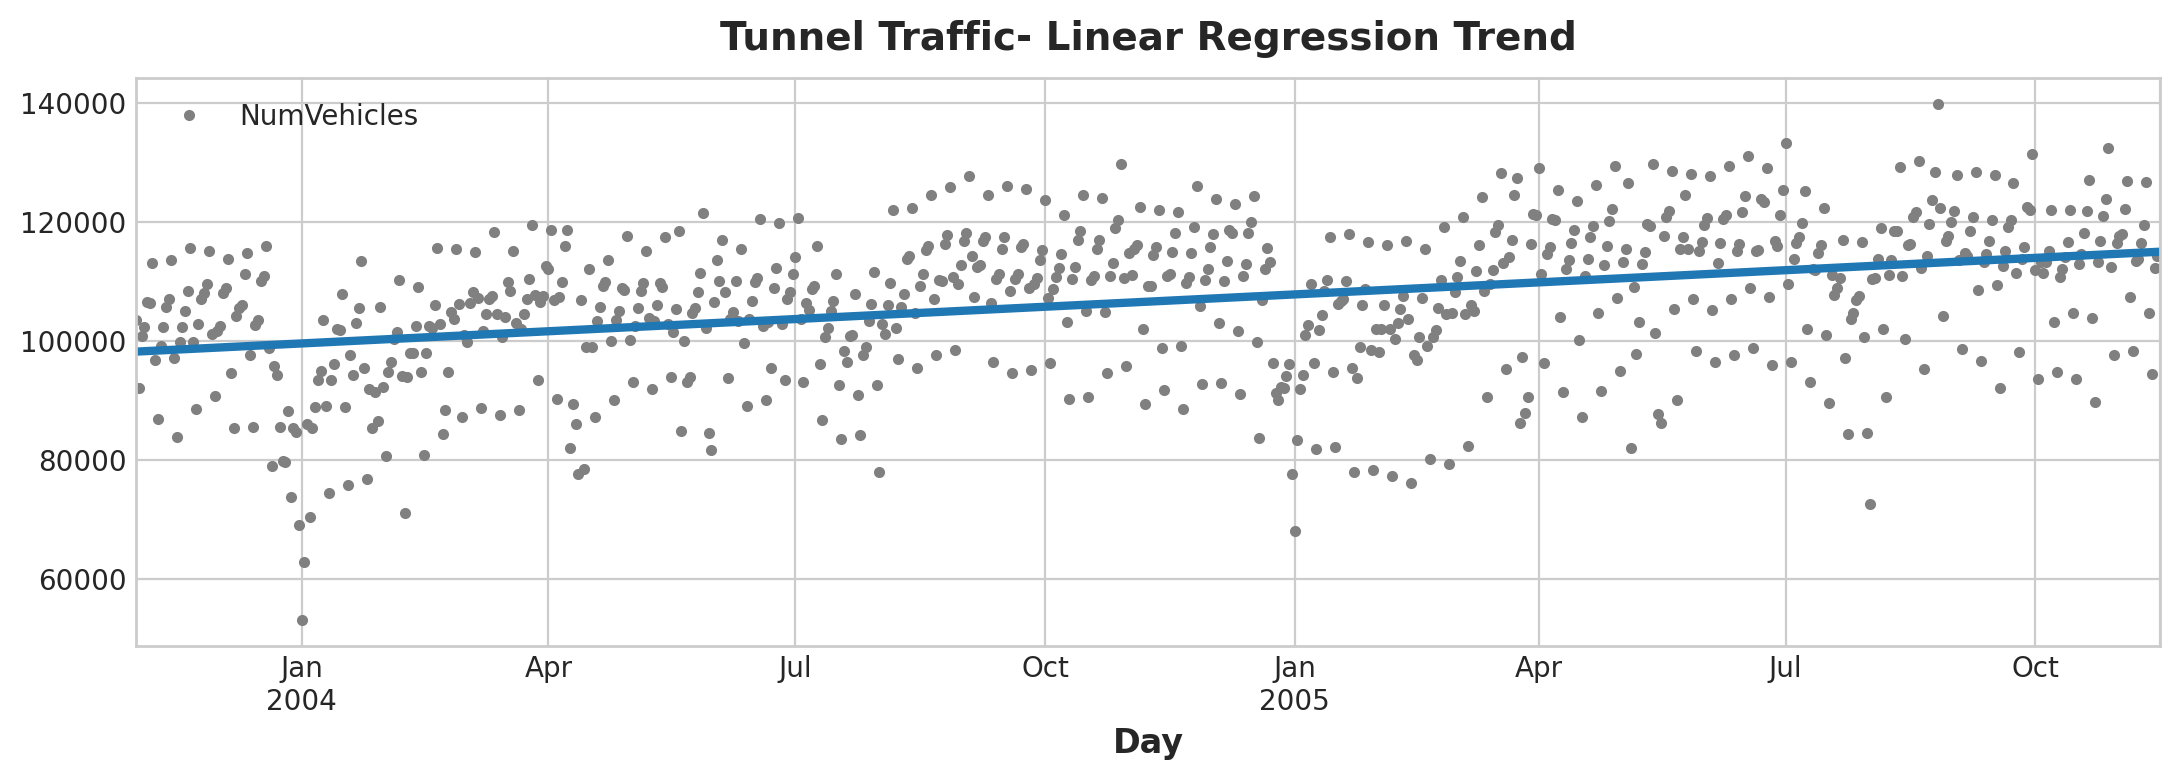

In [39]:
ax = tunnel.plot(style = '.', color = '0.5', title = 'Tunnel Traffic- Linear Regression Trend')
Martin = y_pred.plot(ax=ax, linewidth = 3, label='Trend')

In [41]:
X = dp.out_of_sample(steps = 30)
y_fore = pd.Series(model.predict(X), index = X.index)
y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

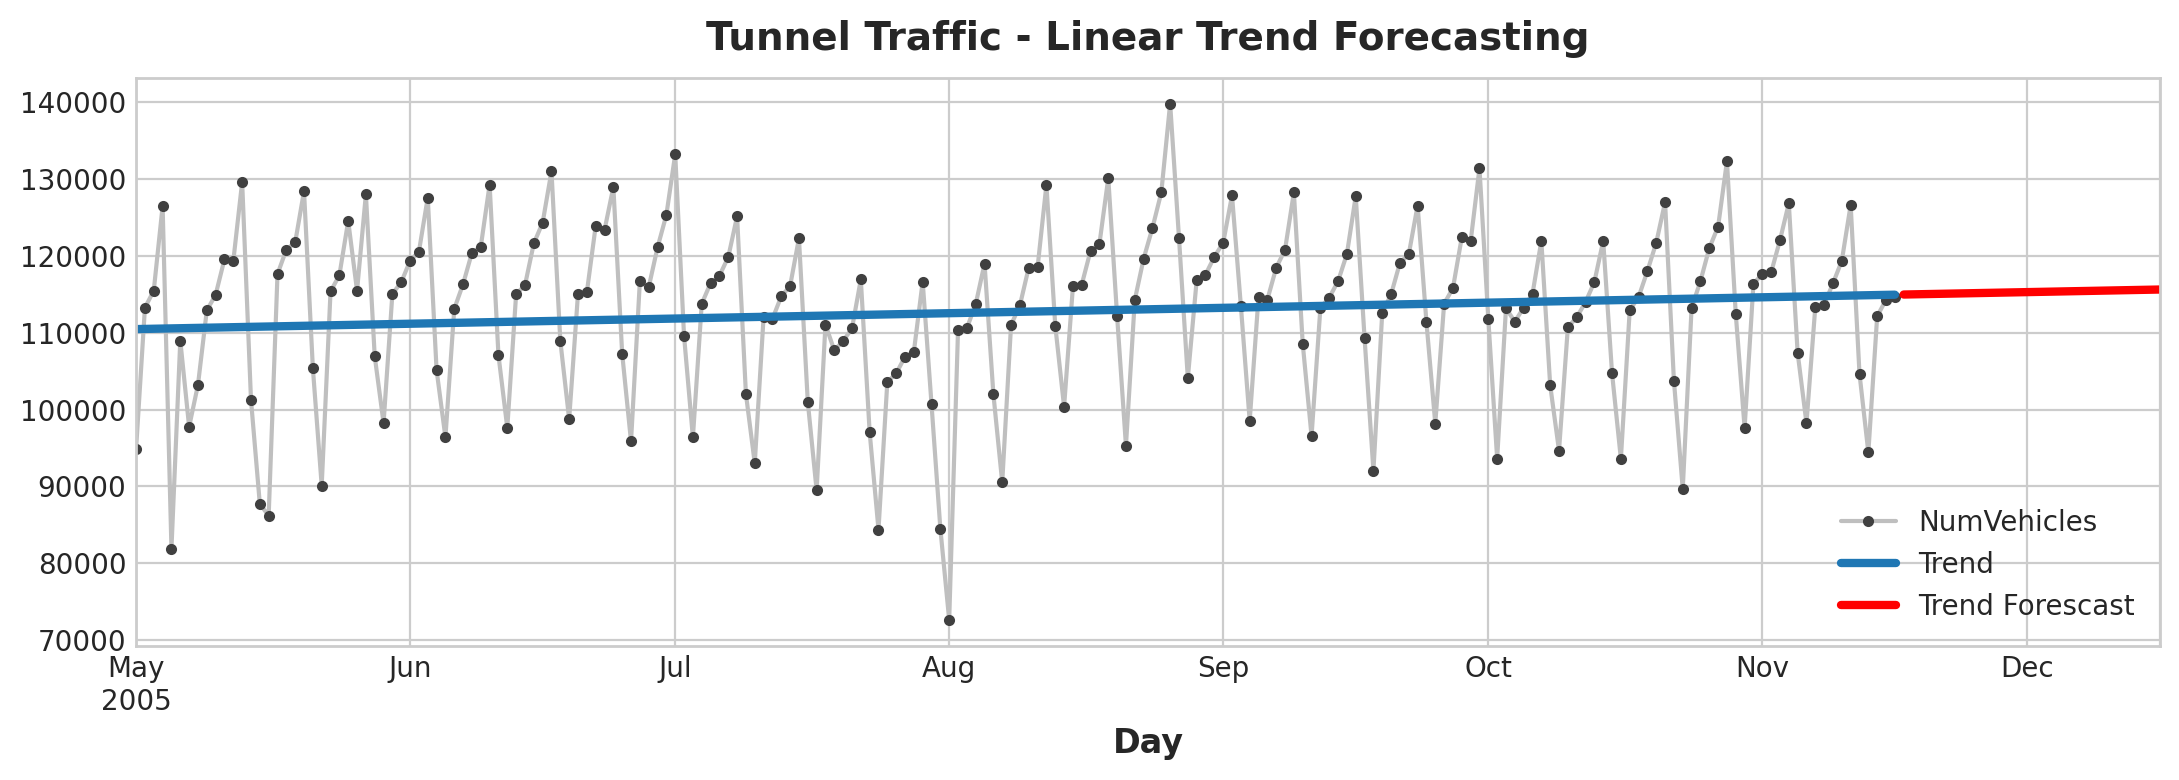

In [42]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecasting", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forescast', color = 'red')
_ = ax.legend()